# CNN
Basit bir CNN yapısı uygulayacağız ilk olarak. 

#### Google Colab Doğrulama

3 tane datasetimiz var. Onlara ulaşabilmek adına doğrulama işlemlerini gerçekleştiriyoruz.


In [3]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}
,

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 145483 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.23-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.23-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Bağlanıp bağlanmadığımız görmek amacıyla drive daki çalışma alanımızın içindekileri listele komutunu çalıştırıyoruz.

In [5]:
ls "/content/drive/My Drive/CT"

checkpoint    denseNet_model_78.h5               my_model_fra.h5  transfer/
covid/        earlystop_model.h5                 non-covid/       works/
COVID/        model.h5                           NonCOVID/
CT_COVID/     model_weights.data-00000-of-00001  Normalize/
CT_NonCOVID/  model_weights.index                saved_models/


#### Kütüphaneler

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import os
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.models import Model,Sequential, Input, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.applications import DenseNet121, MobileNetV2


from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

from keras.callbacks import ModelCheckpoint, EarlyStopping

Normalize edilmiş değerleri önceki ipynb dosyamızda npy olarak kaydetmiştik. Bu aşama, işlemlerimizi hızlandırmak için yapıldı. numpy kütüphanesinden load() metodunu çağırarak normalize olmuş datamızı kullanmaya başlayabiliriz.

In [7]:
a= "/content/drive/My Drive/CT/Normalize/"

#300 veri bulunan dataset
l1x=a+ "X_nparray300.npy"
l1y=a+ "y_nparray300.npy"

#1200 veri bulunan dataset
l2x=a+ "X_nparray1200.npy"
l2y=a+ "y_nparray1200.npy"

#3000 veri bulunan dataset
l3x=a+ "X_nparray3000.npy"
l3y=a+ "y_nparray3000.npy"

loaded_array_x1200 = np.load(l2x)
loaded_array_y1200 = np.load(l2y)

In [8]:
X=loaded_array_x1200
y=loaded_array_y1200

Datamızın doğru yüklendiğine emin olmak için shape metodunu kullanarak inceliyoruz.

In [9]:
print("Shape of input data: {} and shape of target variable: {}".format(X.shape, y.shape))

Shape of input data: (2481, 64, 64, 3) and shape of target variable: (2481, 2)


Verisetimiz üzerinde kaç tane forward ve backward propagation yapılacağını ayarladığımız apoch sayımızı 50,100 ve 200 vereceğiz.

Tüm veri kümesini aynı anda sinir ağına veremeyeceğimiz için dataseti parçalara böleriz. Yani batch size olarak adlandırdığımız bu hiperparametre üzerinde çalışılacak bir parti örneğin miktarını bize söyler. Burada 64'er adet image lar halinde modelimize göndereceğiz.

In [10]:
EPOCHS = 50
# 50, 100, 200
SIZE=64
N_ch=3
BATCH_SIZE = 64
SEED= 42

IMG_W= 64
IMG_H= 64
CHANNELS = 3

INPUT_SHAPE=(IMG_W, IMG_H, CHANNELS)

# CNN Modelimiz

In [11]:
def build_CNN():
  model = Sequential()



  model.add(Conv2D(input_shape= INPUT_SHAPE,filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Dropout(0.5)) 
  model.add(Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
  model.add(Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(Dropout(0.5)) 
  model.add(Conv2D(filters=528,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


  model.add(Flatten())
  model.add(Dense(units=128,activation="relu"))
  model.add(Dense(units=64,activation="relu"))
  model.add(Dense(units=32,activation="relu"))
  model.add(Dense(units=2, activation="softmax"))

  # optimizer = Adam(lr=0.03, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
  optimizer= "adam"
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  model.summary()
  
  return model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 256)       147712    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 256)       0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       590080    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0

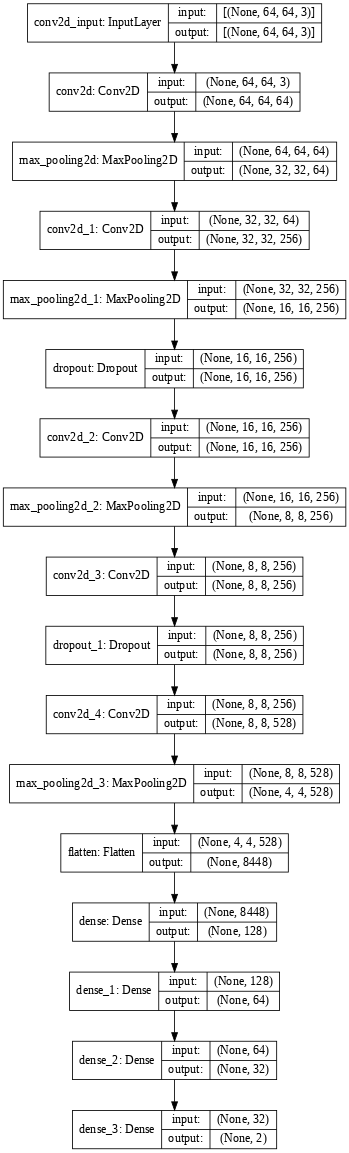

In [12]:
model=build_CNN()
# Modelimizi görselleştirelim
from keras.utils import plot_model

plot_model(model, 
           show_shapes = True, 
           show_layer_names = True, 
           rankdir = 'TB', 
           expand_nested = False, 
           dpi = 60)



In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=SEED)


In [14]:
len(X_train)

1736

In [15]:
len(X_val)

745

In [ ]:
datagen = ImageDataGenerator(rotation_range=360, # rotasyon
                        width_shift_range=0.2, # yatayda shift
                        height_shift_range=0.2, # dikeyde kayma
                        zoom_range=0.2, # büyültme
                        horizontal_flip=True, # yatayda çevirme
                        vertical_flip=True)  #dikeyde çevirme

In [16]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, train_test_split, cross_val_predict, cross_val_score
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import median_absolute_error



annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model_CNN2.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, y_val))



        

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
27/27 - 10s - loss: 0.7021 - accuracy: 0.5017 - val_loss: 0.6931 - val_accuracy: 0.5020

Epoch 00001: val_loss improved from inf to 0.69314, saving model to model_CNN2.h5
Epoch 2/50
27/27 - 2s - loss: 0.6932 - accuracy: 0.4815 - val_loss: 0.6931 - val_accuracy: 0.5020

Epoch 00002: val_loss improved from 0.69314 to 0.69312, saving model to model_CNN2.h5
Epoch 3/50
27/27 - 2s - loss: 0.6932 - accuracy: 0.4809 - val_loss: 0.6931 - val_accuracy: 0.4980

Epoch 00003: val_loss improved from 0.69312 to 0.69311, saving model to model_CNN2.h5
Epoch 4/50
27/27 - 2s - loss: 0.6925 - accuracy: 0.5197 - val_loss: 0.6933 - val_accuracy: 0.4980

Epoch 00004: val_loss did not improve from 0.69311
Epoch 5/50
27/27 - 2s - loss: 0.6936 - accuracy: 0.4934 - val_loss: 0.6932 - val_accuracy: 0.4980

Epoch 00005: val_loss did not improve from 0.69311
Epoch 6/50
27/27 - 2s - loss: 0.6931 - accuracy: 0.5072 - val_loss: 0.6931 - val_accuracy: 0.5020

Epoch 00006: ReduceLROnPlateau reducing learning 

In [30]:
print("training_accuracy   = ", hist.history['accuracy'][-1])
print("validation_accuracy = ", hist.history['val_accuracy'][-1])
print("training_loss   = ", hist.history['loss'][-1])
print("validation_loss = ", hist.history['val_loss'][-1])

training_accuracy   =  0.5083732008934021
validation_accuracy =  0.5020134449005127
training_loss   =  0.6930458545684814
validation_loss =  0.6931687593460083


## Accuracy ve Loss değerlerinin görselleştirilmeleri

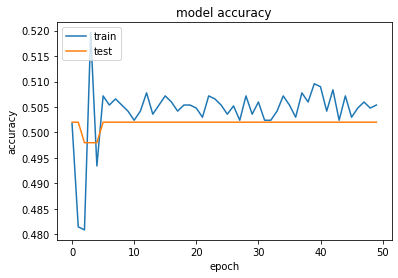

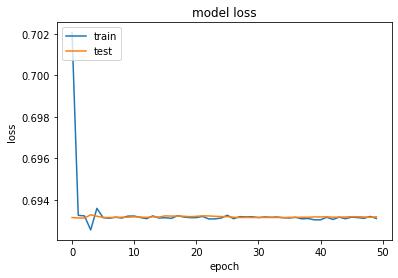

In [18]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Sonuçlar

**Accuracy**:
**Precision**: Yanlış Pozitifin maliyetinin ne kadar yüksek olduğunu belirlemek için kullanılır.<br>
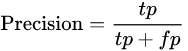 <br>
**Recall**: Pozitif olarak etiketleyerek kaç tane Gerçek Pozitif yakalandığını hesaplar.<br>
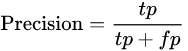<br>

**F1-score**: Hassasiyet(Precision) ve Recall'un ağırlıklı ortalamasıdır.<br>
F1 = 2 × (precision × recall) / (precision + recall)

**Cohen's Kappa**:

**ROC AUC**: ROC eğrisinin altında kalan alan olan AUC tahminler doğrulaştıkça 1 noktasına doğru gitme eğilimindedir.

**R2**:

In [19]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense

y_pred = np.argmax(model.predict(X_val), axis=-1)
y_test= np.argmax(y_val,axis=1)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

#kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)

# precision
pre=precision_score(y_test, y_pred)
print('Precision =  %.3f'%pre)

# confusion matrix
cf = confusion_matrix(y_test, y_pred)
print(cf)

Accuracy: 0.502013
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000
Cohens kappa: 0.000000
ROC AUC: 0.500000
Precision =  0.000
[[374   0]
 [371   0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
def scoreResults(model, x_train, x_test, y_train, y_test):

    y_train_predict = model.predict(x_train)
    y_test_predict = model.predict(x_test)

    r2_train = metrics.r2_score(y_train, y_train_predict)
    r2_test = metrics.r2_score(y_test, y_test_predict)

    mse_train = metrics.mean_squared_error(y_train, y_train_predict)
    mse_test = metrics.mean_squared_error(y_test, y_test_predict)



    return [r2_train, r2_test, mse_train, mse_test]

from sklearn import metrics

lr=model
result_lr = scoreResults(model = lr, x_train = X_train, x_test = X_val, y_train = y_train, y_test = y_val)

print(f"Train R2 Score: {result_lr[0]:.4f} MSE: {result_lr[2]:.4f}")
print(f"Test R2 Score: {result_lr[1]:9.4f} MSE: {result_lr[3]:.4f}")

Train R2 Score: -0.0002 MSE: 0.2500
Test R2 Score:   -0.0004 MSE: 0.2501


### Karmaşıklık Matrisi

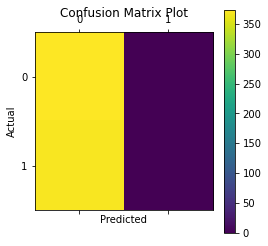

In [21]:
plt.matshow(cf)
plt.title('Confusion Matrix Plot')
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

<Figure size 432x288 with 0 Axes>

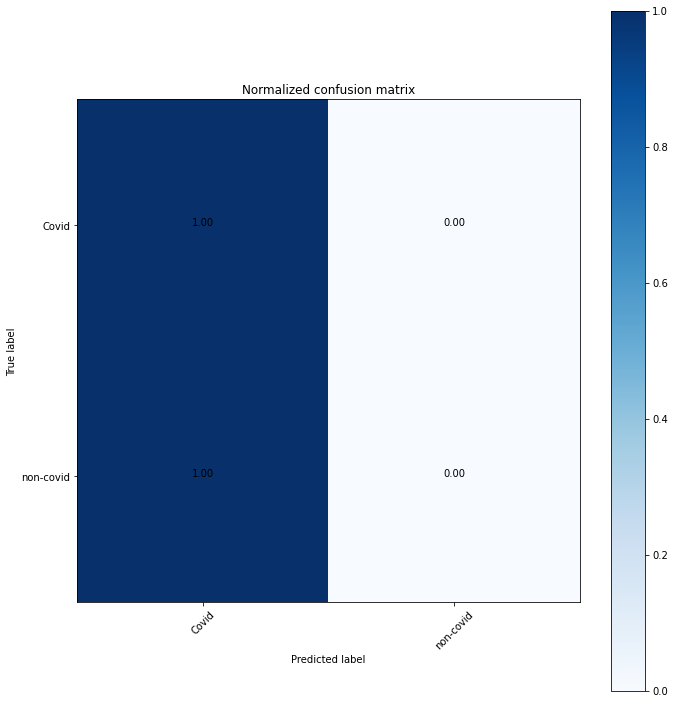

In [22]:


class_names = ["Covid","non-covid"]

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

#### ROC AUC Score

roc_auc_score for Model:  0.5


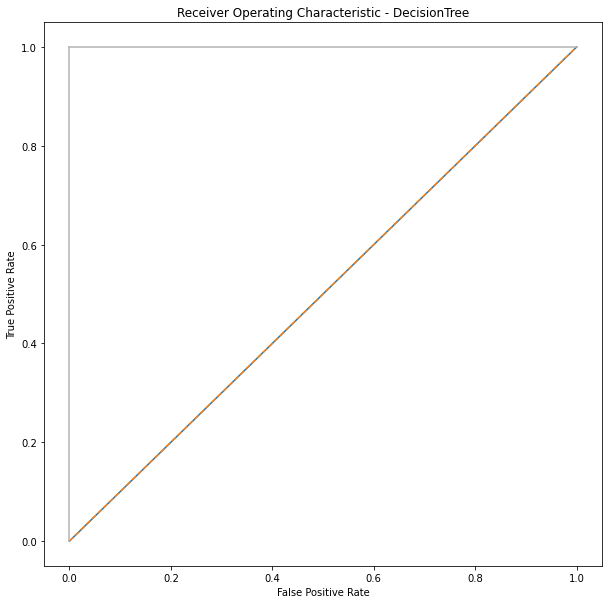

In [23]:
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

fp1, tp1, threshold1 = roc_curve(y_test, y_pred)


def plotRoc():
    plt.subplots(1, figsize=(10,10))
    plt.title('Receiver Operating Characteristic - DecisionTree')
    plt.plot(fp1, tp1)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

print('roc_auc_score for Model: ', roc_auc_score(y_test, y_pred))

plotRoc()

# epoch=100

In [24]:
EPOCHS = 100



In [25]:
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model_CNN2.h5', verbose=1, save_best_only=True)
# Generates batches of image data with data augmentation
datagen = ImageDataGenerator(rotation_range=360, # Degree range for random rotations
                        width_shift_range=0.2, # Range for random horizontal shifts
                        height_shift_range=0.2, # Range for random vertical shifts
                        zoom_range=0.2, # Range for random zoom
                        horizontal_flip=True, # Randomly flip inputs horizontally
                        vertical_flip=True) # Randomly flip inputs vertically

datagen.fit(X_train)
# Fits the model on batches with real-time data augmentation
hist = model.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, y_val))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
27/27 - 2s - loss: 0.6931 - accuracy: 0.5048 - val_loss: 0.6932 - val_accuracy: 0.5020

Epoch 00001: val_loss improved from inf to 0.69324, saving model to model_CNN2.h5
Epoch 2/100
27/27 - 2s - loss: 0.6931 - accuracy: 0.5054 - val_loss: 0.6932 - val_accuracy: 0.5020

Epoch 00002: val_loss improved from 0.69324 to 0.69321, saving model to model_CNN2.h5
Epoch 3/100
27/27 - 2s - loss: 0.6930 - accuracy: 0.5072 - val_loss: 0.6932 - val_accuracy: 0.5020

Epoch 00003: val_loss improved from 0.69321 to 0.69319, saving model to model_CNN2.h5
Epoch 4/100
27/27 - 2s - loss: 0.6932 - accuracy: 0.5042 - val_loss: 0.6932 - val_accuracy: 0.5020

Epoch 00004: val_loss improved from 0.69319 to 0.69318, saving model to model_CNN2.h5
Epoch 5/100
27/27 - 2s - loss: 0.6931 - accuracy: 0.5066 - val_loss: 0.6932 - val_accuracy: 0.5020

Epoch 00005: val_loss improved from 0.69318 to 0.69315, saving model to model_CNN2.h5
Epoch 6/100
27/27 - 2s - loss: 0.6931 - accuracy: 0.5048 - val_loss: 0.693

In [26]:
print("training_accuracy   = ", hist.history['accuracy'][-1])
print("validation_accuracy = ", hist.history['val_accuracy'][-1])
print("training_loss   = ", hist.history['loss'][-1])
print("validation_loss = ", hist.history['val_loss'][-1])

training_accuracy   =  0.5083732008934021
validation_accuracy =  0.5020134449005127
training_loss   =  0.6930458545684814
validation_loss =  0.6931687593460083


# Görselleştirme

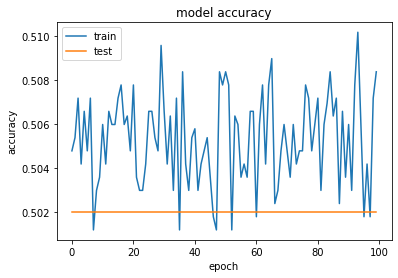

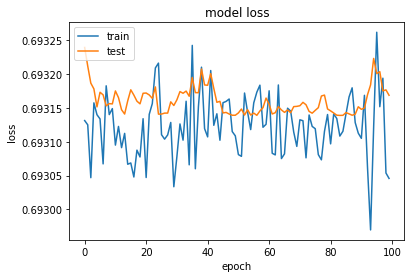

In [27]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# Metriklere göre Sonuçlar

In [28]:
y_pred = np.argmax(model.predict(X_val), axis=-1)
y_test= np.argmax(y_val,axis=1)


# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, y_pred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, y_pred)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, y_pred)
print('F1 score: %f' % f1)

#kappa
kappa = cohen_kappa_score(y_test, y_pred)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(y_test, y_pred)
print('ROC AUC: %f' % auc)

# precision
pre=precision_score(y_test, y_pred)
print('Precision =  %.3f'%pre)

# confusion matrix
cf = confusion_matrix(y_test, y_pred)
print(cf)

Accuracy: 0.502013
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000
Cohens kappa: 0.000000
ROC AUC: 0.500000
Precision =  0.000
[[374   0]
 [371   0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### R2 MSE

In [29]:
def scoreResults(model, x_train, x_test, y_train, y_test):

    y_train_predict = model.predict(x_train)
    y_test_predict = model.predict(x_test)

    r2_train = metrics.r2_score(y_train, y_train_predict)
    r2_test = metrics.r2_score(y_test, y_test_predict)

    mse_train = metrics.mean_squared_error(y_train, y_train_predict)
    mse_test = metrics.mean_squared_error(y_test, y_test_predict)



    return [r2_train, r2_test, mse_train, mse_test]

from sklearn import metrics

lr=model
result_lr = scoreResults(model = lr, x_train = X_train, x_test = X_val, y_train = y_train, y_test = y_val)

print(f"Train R2 Score: {result_lr[0]:.4f} MSE: {result_lr[2]:.4f}")
print(f"Test R2 Score: {result_lr[1]:9.4f} MSE: {result_lr[3]:.4f}")

Train R2 Score: -0.0001 MSE: 0.2500
Test R2 Score:   -0.0004 MSE: 0.2501


# EPOCH KARŞILAŞTIRMA





```
Accuracy: 0.502013
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000
Cohens kappa: 0.000000
ROC AUC: 0.500000
Precision =  0.000
[[374   0]
 [371   0]]

 
Accuracy: 0.502013
Precision: 0.000000
Recall: 0.000000
F1 score: 0.000000
Cohens kappa: 0.000000
ROC AUC: 0.500000
Precision =  0.000
[[374   0]
 [371   0]]
 
 ```

